In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [ ]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [ ]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [ ]:
# train/validation/test 분리 함수 (시계열 데이터용, 6:2:2 비율)
def split_train_val_test(df):
    n = len(df)

    # 데이터셋 크기 계산
    train_end = int(0.6 * n)
    val_end = int(0.8 * n)  # 0.6 + 0.2

    # 순차적으로 데이터 분할
    train_data = df[:train_end]     # 처음 60%는 train 데이터
    val_data = df[train_end:val_end] # 그 다음 20%는 validation 데이터
    test_data = df[val_end:]        # 마지막 20%는 test 데이터

    # 데이터 크기 출력 (원한다면)
    # print("Train set:", train_data.shape)
    # print("Validation set:", val_data.shape)
    # print("Test set:", test_data.shape)

    return train_data, val_data, test_data

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [ ]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 성능 테스트 함수

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluation(y_test, y_pred):

    # MSE (Mean Squared Error) 계산
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # MAE (Mean Absolute Error) 계산
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")

    # 예측 결과와 실제 값을 비교하는 샘플 출력
    for i in range(5):  # 예시로 첫 5개만 출력
        print(f"Actual: {y_test[i]}, Predicted: {y_pred[i]}")

## 전처리

### 1. 데이터셋 가져오기

In [ ]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/drive/MyDrive/deep-uav/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [ ]:
df = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lat'])
new_x, lon = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lon'])
new_x, alt = spline_interpolation(df['Timpstemp'] / 1e6 , df[' alt'])

df = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

df = truncation(df)
scaler, df = min_max_scaling(df)

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- GRU를 사용한 모델 클래스 선언
- 구조 : GRU + Fully Connected Layer

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 하이퍼파라미터와 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력만 사용
        return out

## 하이퍼파라미터 탐색

### 1. Optuna 의 objective 함수 선언

+ 최적의 하이퍼파라미터 탐색을 위해 optuna 사용
+ objective 함수 선언

In [ ]:
# Optuna의 목적 함수 정의
def objective(trial, df, sequence_length):
    # 하이퍼파라미터 탐색 범위
    n_layers = trial.suggest_int('n_layers', 1, 5)
    n_units_l0 = trial.suggest_int('n_units_l0', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    # 메인 코드
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader, test_loader = prepare_dataloader(df, batch_size, sequence_length)

    # 첫 번째 배치를 가져와 input_size, output_size 계산
    first_batch = next(iter(train_loader))
    X_train_batch, y_train_batch = first_batch
    input_size = X_train_batch.shape[2]  # 입력 데이터의 feature 크기
    output_size = y_train_batch.shape[1]  # 예측할 값의 크기

    early_stopping_patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 모델 및 데이터 설정
    model = GRUModel(input_size, n_units_l0, output_size, n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 모델 학습
    for epoch in range(300):
        train_loss = train_model(model, criterion, optimizer, train_loader, device, None)
        val_loss, _, _ = evaluate_model(model, criterion, val_loader, device, None)

        # Early Stopping 조건 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # 개선되면 카운터 초기화
        else:
            patience_counter += 1  # 개선되지 않으면 카운터 증가

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optuna에 학습 결과 보고
        trial.report(val_loss, epoch)

        # Pruning: 성능이 개선되지 않으면 중단
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

In [ ]:
# 모델 학습 함수
def train_model(model, criterion, optimizer, loader, device, history):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    # history가 주어지면 학습 손실 기록
    if history is not None:
        history['train_loss'].append(avg_loss)

    return avg_loss

In [ ]:
# 검증 및 테스트 함수
def evaluate_model(model, criterion, loader, device, history):
    model.eval()
    total_loss = 0
    true_values = []
    predictions = []

    start_time = time.time()  # 예측 시작 시간 기록

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            true_values.append(batch_y.cpu().numpy())
            predictions.append(output.cpu().numpy())

    end_time = time.time()  # 예측 종료 시간 기록
    total_inference_time = end_time - start_time

    # print(f"Total Inference Time: {total_inference_time:.2f} seconds")

    avg_loss = total_loss / len(loader)

    # history가 주어지면 검증 손실 기록
    if history is not None:
        history['val_loss'].append(avg_loss)

    return avg_loss, true_values, predictions

## 학습

### 1. 데이터 준비

1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader에 load

In [ ]:
# 데이터 로더 생성 함수
def prepare_dataloader(df, batch_size, sequence_length, look_back=10, forward=0):

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(df)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back, forward)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back, forward)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back, forward)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [ ]:
sequence_length = 10

#### 1. early stopping 함수 선언

In [ ]:
import optuna
# import logging

# # Optuna 로깅을 위해 로거 설정
# optuna.logging.set_verbosity(optuna.logging.INFO)  # 디폴트 로깅 수준 설정

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(lambda trial: objective(trial, df, sequence_length), n_trials=100)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-13 15:57:45,381] A new study created in memory with name: no-name-909b4636-bc95-4697-9405-936a77225623
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:00:02,223] Trial 0 finished with value: 5.0745446287692175e-05 and parameters: {'n_layers': 4, 'n_units_l0': 118, 'learning_rate': 0.0015687814663622724, 'batch_size': 82}. Best is trial 0 with value: 5.0745446287692175e-05.


Early stopping at epoch 47


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:12:05,003] Trial 1 finished with value: 0.00013992713982133865 and parameters: {'n_layers': 5, 'n_units_l0': 85, 'learning_rate': 2.6287529904171067e-05, 'batch_size': 27}. Best is trial 0 with value: 5.0745446287692175e-05.


Early stopping at epoch 168


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:12:18,603] Trial 2 finished with value: 0.06048138634650968 and parameters: {'n_layers': 1, 'n_units_l0': 68, 'learning_rate': 1.4611394278718135e-05, 'batch_size': 69}. Best is trial 0 with value: 5.0745446287692175e-05.


Early stopping at epoch 29


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:14:54,860] Trial 3 finished with value: 7.657033878179693e-05 and parameters: {'n_layers': 4, 'n_units_l0': 64, 'learning_rate': 0.00045514273053953714, 'batch_size': 94}. Best is trial 0 with value: 5.0745446287692175e-05.


Early stopping at epoch 121


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:15:31,850] Trial 4 finished with value: 0.00010479388477809455 and parameters: {'n_layers': 1, 'n_units_l0': 62, 'learning_rate': 0.0003564983084638926, 'batch_size': 46}. Best is trial 0 with value: 5.0745446287692175e-05.


Early stopping at epoch 66


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:19:07,864] Trial 5 finished with value: 5.681948969140649e-05 and parameters: {'n_layers': 4, 'n_units_l0': 102, 'learning_rate': 0.00037475405367037916, 'batch_size': 114}. Best is trial 0 with value: 5.0745446287692175e-05.


Early stopping at epoch 101


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:19:44,416] Trial 6 finished with value: 3.7207298104336725e-05 and parameters: {'n_layers': 2, 'n_units_l0': 102, 'learning_rate': 0.0017327338988678102, 'batch_size': 43}. Best is trial 6 with value: 3.7207298104336725e-05.


Early stopping at epoch 23


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:20:43,100] Trial 7 finished with value: 2.7844150703718435e-05 and parameters: {'n_layers': 1, 'n_units_l0': 82, 'learning_rate': 0.0010185544933761573, 'batch_size': 82}. Best is trial 7 with value: 2.7844150703718435e-05.


Early stopping at epoch 128


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:21:15,362] Trial 8 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:22:55,138] Trial 9 finished with value: 0.00010938613774090878 and parameters: {'n_layers': 5, 'n_units_l0': 103, 'learning_rate': 0.003009121783064874, 'batch_size': 98}. Best is trial 7 with value: 2.7844150703718435e-05.


Early stopping at epoch 33


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:24:34,095] Trial 10 finished with value: 2.4220125346295794e-05 and parameters: {'n_layers': 2, 'n_units_l0': 173, 'learning_rate': 0.007785634033909695, 'batch_size': 124}. Best is trial 10 with value: 2.4220125346295794e-05.


Early stopping at epoch 47


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:25:52,377] Trial 11 finished with value: 2.090559352533698e-05 and parameters: {'n_layers': 2, 'n_units_l0': 168, 'learning_rate': 0.008622439105646827, 'batch_size': 127}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 41


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:27:28,213] Trial 12 finished with value: 2.8416911441632288e-05 and parameters: {'n_layers': 2, 'n_units_l0': 181, 'learning_rate': 0.0069639769976329825, 'batch_size': 126}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 44


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:28:29,075] Trial 13 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:30:42,162] Trial 14 finished with value: 2.9464628162465736e-05 and parameters: {'n_layers': 3, 'n_units_l0': 160, 'learning_rate': 0.0040361888752334435, 'batch_size': 103}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 47


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:31:14,044] Trial 15 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:31:43,906] Trial 16 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 58


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:33:38,371] Trial 18 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:36:33,743] Trial 19 finished with value: 3.0732893439842606e-05 and parameters: {'n_layers': 3, 'n_units_l0': 206, 'learning_rate': 0.002848928438351962, 'batch_size': 85}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 38


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:39:13,651] Trial 20 finished with value: 2.6872138177067325e-05 and parameters: {'n_layers': 2, 'n_units_l0': 224, 'learning_rate': 0.009924287718108934, 'batch_size': 62}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 49


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:41:31,434] Trial 21 finished with value: 2.917785090367512e-05 and parameters: {'n_layers': 2, 'n_units_l0': 239, 'learning_rate': 0.0099998971057985, 'batch_size': 57}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 35


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:42:55,980] Trial 22 finished with value: 2.2808557264397678e-05 and parameters: {'n_layers': 2, 'n_units_l0': 180, 'learning_rate': 0.004418423089252361, 'batch_size': 18}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 20


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:45:35,282] Trial 23 finished with value: 3.40039129885857e-05 and parameters: {'n_layers': 3, 'n_units_l0': 171, 'learning_rate': 0.00430058418837226, 'batch_size': 18}. Best is trial 11 with value: 2.090559352533698e-05.


Early stopping at epoch 26


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:45:46,609] Trial 24 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:46:28,384] Trial 25 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 45


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:51:04,442] Trial 27 finished with value: 1.9825683436162458e-05 and parameters: {'n_layers': 2, 'n_units_l0': 185, 'learning_rate': 0.0027408337177810883, 'batch_size': 76}. Best is trial 27 with value: 1.9825683436162458e-05.


Early stopping at epoch 60


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:52:16,271] Trial 28 finished with value: 2.907923559784346e-05 and parameters: {'n_layers': 1, 'n_units_l0': 212, 'learning_rate': 0.001288091158182298, 'batch_size': 53}. Best is trial 27 with value: 1.9825683436162458e-05.


Early stopping at epoch 51


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:54:09,739] Trial 29 finished with value: 3.3226033641161244e-05 and parameters: {'n_layers': 3, 'n_units_l0': 122, 'learning_rate': 0.0023564589054098253, 'batch_size': 76}. Best is trial 27 with value: 1.9825683436162458e-05.


Early stopping at epoch 52


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:55:20,995] Trial 30 finished with value: 3.0238855543984755e-05 and parameters: {'n_layers': 2, 'n_units_l0': 186, 'learning_rate': 0.003251632804752904, 'batch_size': 34}. Best is trial 27 with value: 1.9825683436162458e-05.


Early stopping at epoch 22


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:56:51,168] Trial 31 finished with value: 2.0162976782370714e-05 and parameters: {'n_layers': 2, 'n_units_l0': 171, 'learning_rate': 0.006136726471157799, 'batch_size': 16}. Best is trial 27 with value: 1.9825683436162458e-05.


Early stopping at epoch 21


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:58:26,014] Trial 32 finished with value: 2.7282998856511162e-05 and parameters: {'n_layers': 2, 'n_units_l0': 146, 'learning_rate': 0.005660880009702556, 'batch_size': 18}. Best is trial 27 with value: 1.9825683436162458e-05.


Early stopping at epoch 29


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 16:59:53,139] Trial 33 finished with value: 2.0287404009877718e-05 and parameters: {'n_layers': 1, 'n_units_l0': 171, 'learning_rate': 0.0016052300108144286, 'batch_size': 27}. Best is trial 27 with value: 1.9825683436162458e-05.


Early stopping at epoch 59


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:00:08,514] Trial 34 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:02:29,916] Trial 35 finished with value: 1.719932339754104e-05 and parameters: {'n_layers': 1, 'n_units_l0': 202, 'learning_rate': 0.0014729861305493907, 'batch_size': 26}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 79


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:02:47,189] Trial 36 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:04:03,740] Trial 37 finished with value: 2.6333895479266093e-05 and parameters: {'n_layers': 1, 'n_units_l0': 223, 'learning_rate': 0.0014841158383116042, 'batch_size': 25}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 37


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:04:21,328] Trial 38 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:04:34,575] Trial 39 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 46


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:07:21,274] Trial 42 finished with value: 1.8869269623185878e-05 and parameters: {'n_layers': 1, 'n_units_l0': 164, 'learning_rate': 0.0067225834033987405, 'batch_size': 36}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 34


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:08:46,563] Trial 43 finished with value: 1.8355208438454915e-05 and parameters: {'n_layers': 1, 'n_units_l0': 203, 'learning_rate': 0.003506804926818824, 'batch_size': 36}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 56


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:09:01,675] Trial 44 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:10:34,444] Trial 45 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 20


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:11:48,571] Trial 47 finished with value: 2.2426389644071885e-05 and parameters: {'n_layers': 1, 'n_units_l0': 232, 'learning_rate': 0.006966896887258509, 'batch_size': 21}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 21


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:12:35,055] Trial 48 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:13:17,109] Trial 49 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 66


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:16:13,691] Trial 52 finished with value: 2.4137258782906833e-05 and parameters: {'n_layers': 1, 'n_units_l0': 197, 'learning_rate': 0.0020414839769273383, 'batch_size': 30}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 37


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:16:50,691] Trial 53 finished with value: 3.182009272120699e-05 and parameters: {'n_layers': 1, 'n_units_l0': 163, 'learning_rate': 0.002635389256283089, 'batch_size': 22}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 21


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:18:07,557] Trial 54 finished with value: 3.698629742151146e-05 and parameters: {'n_layers': 2, 'n_units_l0': 191, 'learning_rate': 0.005316477789105024, 'batch_size': 37}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 23


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:19:09,478] Trial 55 finished with value: 2.2876045341035935e-05 and parameters: {'n_layers': 1, 'n_units_l0': 204, 'learning_rate': 0.00333432724785849, 'batch_size': 54}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 47


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:19:50,546] Trial 56 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:20:55,327] Trial 57 finished with value: 1.8822077553228583e-05 and parameters: {'n_layers': 1, 'n_units_l0': 179, 'learning_rate': 0.004470849669309394, 'batch_size': 16}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 30


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:21:09,427] Trial 58 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:21:19,010] Trial 59 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 54


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:24:31,098] Trial 61 finished with value: 2.1732998054456122e-05 and parameters: {'n_layers': 1, 'n_units_l0': 217, 'learning_rate': 0.004343284752271878, 'batch_size': 21}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 31


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:25:22,882] Trial 62 finished with value: 2.775838555036994e-05 and parameters: {'n_layers': 1, 'n_units_l0': 229, 'learning_rate': 0.0021149024004861673, 'batch_size': 29}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 26


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:26:10,616] Trial 63 finished with value: 3.299633597131841e-05 and parameters: {'n_layers': 1, 'n_units_l0': 206, 'learning_rate': 0.0045696813845856115, 'batch_size': 23}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 24


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:26:44,711] Trial 64 finished with value: 3.709569123470026e-05 and parameters: {'n_layers': 1, 'n_units_l0': 194, 'learning_rate': 0.0029757810616167463, 'batch_size': 32}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 22


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:27:39,635] Trial 65 finished with value: 2.110671979113142e-05 and parameters: {'n_layers': 1, 'n_units_l0': 184, 'learning_rate': 0.0075540314534382445, 'batch_size': 16}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 25


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:28:44,613] Trial 66 finished with value: 2.8433915173309287e-05 and parameters: {'n_layers': 1, 'n_units_l0': 245, 'learning_rate': 0.0017708887373612701, 'batch_size': 27}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 30


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:30:22,326] Trial 67 finished with value: 2.086103900182934e-05 and parameters: {'n_layers': 2, 'n_units_l0': 163, 'learning_rate': 0.0037543905655060116, 'batch_size': 37}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 37


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:30:36,693] Trial 68 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:31:20,644] Trial 69 finished with value: 2.679388426958422e-05 and parameters: {'n_layers': 1, 'n_units_l0': 212, 'learning_rate': 0.0047683457173621395, 'batch_size': 87}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 35


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:33:24,243] Trial 70 finished with value: 2.860072091876915e-05 and parameters: {'n_layers': 2, 'n_units_l0': 178, 'learning_rate': 0.0008561504125914874, 'batch_size': 20}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 32


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:34:52,176] Trial 71 finished with value: 4.58673672282577e-05 and parameters: {'n_layers': 2, 'n_units_l0': 190, 'learning_rate': 0.005992220560409138, 'batch_size': 16}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 18


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:35:47,027] Trial 72 finished with value: 2.205023432300853e-05 and parameters: {'n_layers': 1, 'n_units_l0': 167, 'learning_rate': 0.008861207480327375, 'batch_size': 24}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 36


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:36:19,983] Trial 73 finished with value: 2.144137649143626e-05 and parameters: {'n_layers': 1, 'n_units_l0': 176, 'learning_rate': 0.005989583202519609, 'batch_size': 26}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 22


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:38:09,657] Trial 74 finished with value: 2.7453678276961675e-05 and parameters: {'n_layers': 2, 'n_units_l0': 202, 'learning_rate': 0.002961061940775637, 'batch_size': 20}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 24


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:39:17,787] Trial 75 finished with value: 3.9021002612571466e-05 and parameters: {'n_layers': 3, 'n_units_l0': 132, 'learning_rate': 0.003777049309937354, 'batch_size': 31}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 19


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:39:34,828] Trial 76 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:40:24,911] Trial 77 finished with value: 3.2922246926038774e-05 and parameters: {'n_layers': 1, 'n_units_l0': 227, 'learning_rate': 0.002110674750176801, 'batch_size': 42}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 30


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:41:14,537] Trial 78 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:41:26,149] Trial 79 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 33


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:44:53,712] Trial 81 finished with value: 1.97117024569593e-05 and parameters: {'n_layers': 1, 'n_units_l0': 172, 'learning_rate': 0.0015141599283671659, 'batch_size': 34}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 64


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:45:40,809] Trial 82 finished with value: 3.2820562140045695e-05 and parameters: {'n_layers': 1, 'n_units_l0': 171, 'learning_rate': 0.0015443527727187817, 'batch_size': 34}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 35


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:46:19,596] Trial 83 finished with value: 2.8087293515000056e-05 and parameters: {'n_layers': 1, 'n_units_l0': 162, 'learning_rate': 0.002317599976778932, 'batch_size': 45}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 36


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:47:25,072] Trial 84 finished with value: 1.79101232613009e-05 and parameters: {'n_layers': 1, 'n_units_l0': 139, 'learning_rate': 0.0018770052623437801, 'batch_size': 19}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 44


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:47:28,734] Trial 85 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:47:37,455] Trial 86 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('

Early stopping at epoch 34


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:50:23,827] Trial 89 finished with value: 1.76453265721061e-05 and parameters: {'n_layers': 1, 'n_units_l0': 217, 'learning_rate': 0.002745678854074094, 'batch_size': 35}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 52


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:50:44,677] Trial 90 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:51:55,751] Trial 91 finished with value: 2.052101660107534e-05 and parameters: {'n_layers': 1, 'n_units_l0': 217, 'learning_rate': 0.0029360924356913163, 'batch_size': 24}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 37


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:53:08,612] Trial 92 finished with value: 2.4474958831046092e-05 and parameters: {'n_layers': 1, 'n_units_l0': 214, 'learning_rate': 0.0024092396227665073, 'batch_size': 40}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 48


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:54:24,124] Trial 93 finished with value: 1.9736738134751623e-05 and parameters: {'n_layers': 1, 'n_units_l0': 203, 'learning_rate': 0.003306787171026056, 'batch_size': 32}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 47


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:55:35,550] Trial 94 finished with value: 2.1480161169367624e-05 and parameters: {'n_layers': 1, 'n_units_l0': 209, 'learning_rate': 0.0040277345340839245, 'batch_size': 30}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 43


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:56:58,189] Trial 95 finished with value: 2.0159508163818497e-05 and parameters: {'n_layers': 1, 'n_units_l0': 199, 'learning_rate': 0.001936822652296432, 'batch_size': 33}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 52


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:57:20,107] Trial 96 finished with value: 3.287866063502683e-05 and parameters: {'n_layers': 1, 'n_units_l0': 127, 'learning_rate': 0.003416867061666066, 'batch_size': 47}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 26


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:57:37,806] Trial 97 pruned. 
<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 17:59:36,337] Trial 98 finished with value: 1.8219246040614728e-05 and parameters: {'n_layers': 1, 'n_units_l0': 204, 'learning_rate': 0.0017009178321840438, 'batch_size': 35}. Best is trial 35 with value: 1.719932339754104e-05.


Early stopping at epoch 78


<ipython-input-44-e00e9b832e9e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-13 18:01:00,833] Trial 99 pruned. 


Best hyperparameters:  {'n_layers': 1, 'n_units_l0': 202, 'learning_rate': 0.0014729861305493907, 'batch_size': 26}


#### 2. 하이퍼파라미터 저장

In [ ]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters_1014.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


#### 3. 하이퍼파라미터 불러오기

In [ ]:
import json

# # 1. 저장된 하이퍼파라미터 불러오기
# with open("best_hyperparameters.json", "r") as f:
#     best_params = json.load(f)

# print("Loaded best hyperparameters:", best_params)
# best_params = {'n_layers': 2, 'n_units_l0': 42, 'learning_rate': 0.00038256881298005026, 'batch_size': 31}

### 3. 최적의 파라미터로 모델 학습

In [ ]:
# 최적의 모델 학습
best_params = study.best_params

train_loader, val_loader, test_loader = prepare_dataloader(df, best_params['batch_size'], sequence_length)

best_model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

In [ ]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수
history = {'train_loss': [], 'val_loss': []}

num_epochs = 500
for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # history가 주어지면 학습 손실 기록
    history['train_loss'].append(train_loss / len(train_loader))

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()


    # history가 주어지면 학습 손실 기록
    history['val_loss'].append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    # model_save_path = f"/content/drive/MyDrive/deep-uav/best_model_epoch_{epoch+1}.pth"
    # torch.save(best_model.state_dict(), model_save_path)
    # print(f"Model saved: {model_save_path}")

    # Model Save
    model_save_path = f"/content/drive/MyDrive/deep-uav/best_model_1014_epoch_{epoch+1}.pth"
    torch.save({
      'model_state_dict': best_model.state_dict(),
      'train_losses': history['train_loss'],
      'val_losses': history['val_loss']
    }, model_save_path)
    print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{500} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/500], Train Loss: 0.0416, Val Loss: 0.0107
Model saved: /content/drive/MyDrive/deep-uav/best_model_1014_epoch_1.pth
Epoch 1/500 completed in 3.35 seconds.
Epoch [2/500], Train Loss: 0.0194, Val Loss: 0.0044
Model saved: /content/drive/MyDrive/deep-uav/best_model_1014_epoch_2.pth
Epoch 2/500 completed in 2.17 seconds.
Epoch [3/500], Train Loss: 0.0143, Val Loss: 0.0051
Model saved: /content/drive/MyDrive/deep-uav/best_model_1014_epoch_3.pth
Epoch 3/500 completed in 1.37 seconds.
Epoch [4/500], Train Loss: 0.0143, Val Loss: 0.0050
Model saved: /content/drive/MyDrive/deep-uav/best_model_1014_epoch_4.pth
Epoch 4/500 completed in 1.38 seconds.
Epoch [5/500], Train Loss: 0.0127, Val Loss: 0.0029
Model saved: /content/drive/MyDrive/deep-uav/best_model_1014_epoch_5.pth
Epoch 5/500 completed in 1.55 seconds.
Epoch [6/500], Train Loss: 0.0090, Val Loss: 0.0048
Model saved: /content/drive/MyDrive/deep-uav/best_model_1014_epoch_6.pth
Epoch 6/500 completed in 1.47 seconds.
Epoch [7/500], T

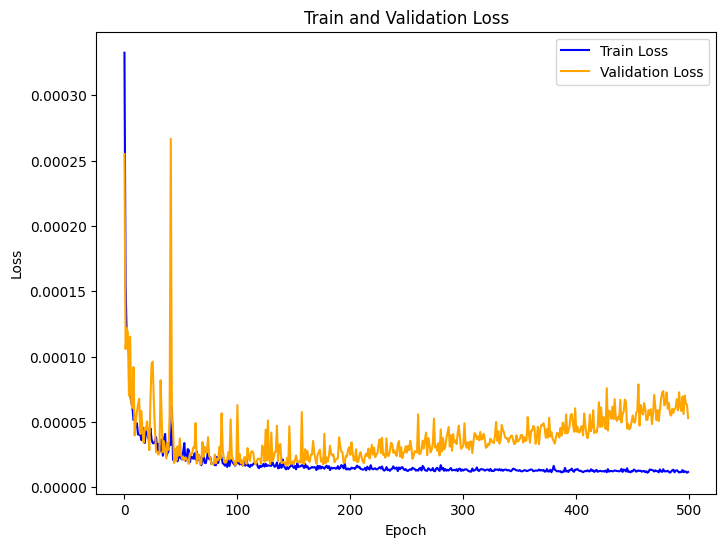

In [ ]:
import matplotlib.pyplot as plt

# 학습 후 손실 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 202]              125,442
├─Linear: 1-2                            [1, 3]                    609
Total params: 126,051
Trainable params: 126,051
Non-trainable params: 0
Total mult-adds (M): 1.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.50
Estimated Total Size (MB): 0.52

## 테스트

### 1. 테스트 결과 생성

In [65]:
# 모델 초기화 (저장할 때 사용한 것과 동일한 구조로)
model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])

# GPU 사용 가능 시 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 저장된 모델 가중치 불러오기
model.load_state_dict(torch.load("/content/drive/MyDrive/deep-uav/best_model_1014_epoch_150.pth", map_location=device)["model_state_dict"])

# 평가 모드로 전환 (dropout 등을 비활성화)
model.eval()

<ipython-input-65-38ba871d47c5>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/deep-uav/best_model_1014_epoch_150.

GRUModel(
  (gru): GRU(3, 202, batch_first=True)
  (fc): Linear(in_features=202, out_features=3, bias=True)
)

In [ ]:
# best_model = model
# train_loader, val_loader, test_loader = prepare_dataloader(df, 17, 10)
# criterion = torch.nn.MSELoss()

In [66]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 1.4288241800386459e-05
Mean Absolute Error (MAE): 0.002365535357967019


### 2. 결과 시각화

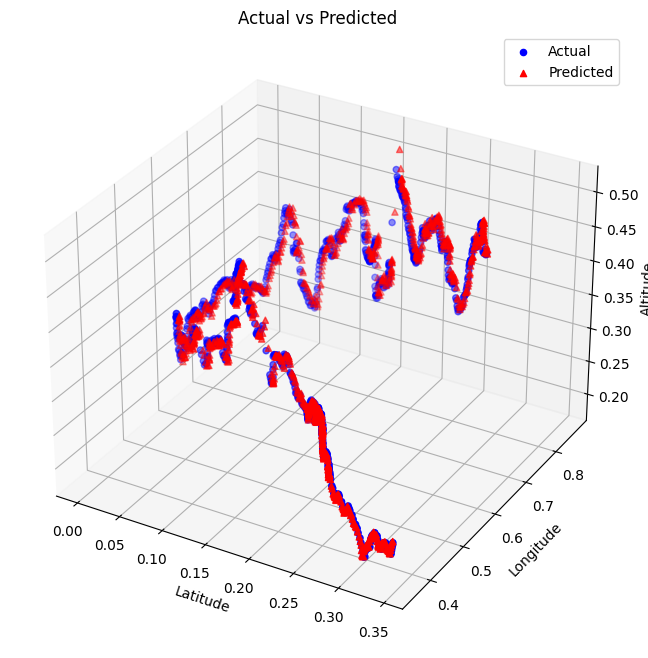

In [67]:
prediction_visualization(y_true, y_pred)

Todo
- min max scaling 풀어서, raw랑 찍어보기
- epoch이랑 batch, learning rate 찍어보기
- 파라미터 수 측정
- 모델 구조 출려 코드

#### 3. raw 데이터와 predict 데이터 비교

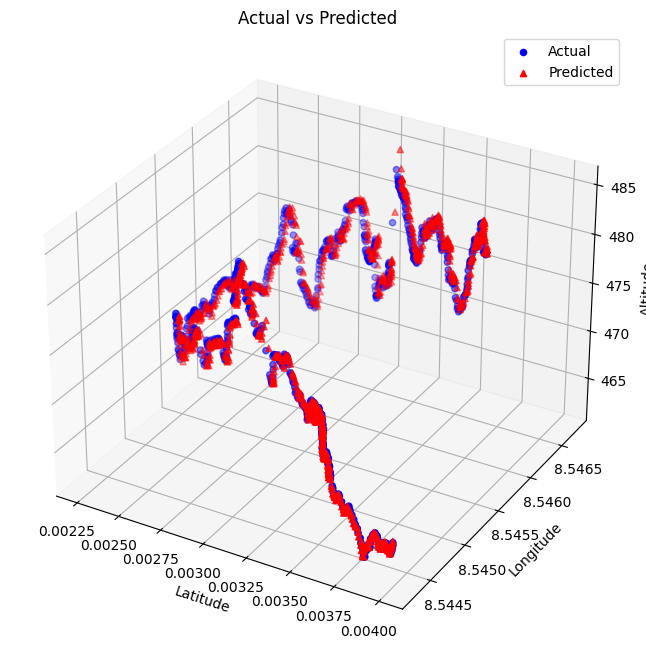

In [68]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

# 기타

In [ ]:
# # 최적의 하이퍼파라미터로 모델 학습 및 평가
# def train_and_evaluate(best_params, num_epochs=50):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_loader, val_loader, test_loader = prepare_dataloader(X_train, X_val, X_test, y_train, y_val, y_test, best_params['batch_size'])

#     # 첫 번째 배치로 input/output 크기 결정
#     first_batch = next(iter(train_loader))
#     input_size = first_batch[0].shape[2]
#     output_size = first_batch[1].shape[1]

#     # 모델 초기화
#     model = GRUModel(input_size, best_params['n_units_l0'], output_size, best_params['n_layers'], best_params['dropout']).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

#     # 학습 및 검증 기록
#     history = {'train_loss': [], 'val_loss': []}

#     start_time = time.time() # 학습 시작 시간 기록

#     for epoch in range(num_epochs):
#         train_loss = train_model(model, criterion, optimizer, train_loader, device)
#         val_loss, _, _ = evaluate_model(model, criterion, val_loader, device)
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#     end_time = time.time()
#     total_training_time = end_time - start_time

#     print(f"Total Training Time: {total_training_time:.2f} seconds")

#     return model, history

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # 학습 중 기록된 train_loss와 val_loss 그래프 그리기
    epochs = len(history['train_loss'])  # 기록된 에포크 수
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.plot(range(epochs), history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_loss(best_model.history)

AttributeError: 'GRUModel' object has no attribute 'history'

Total Inference Time: 0.37 seconds
Test Loss: 0.0001


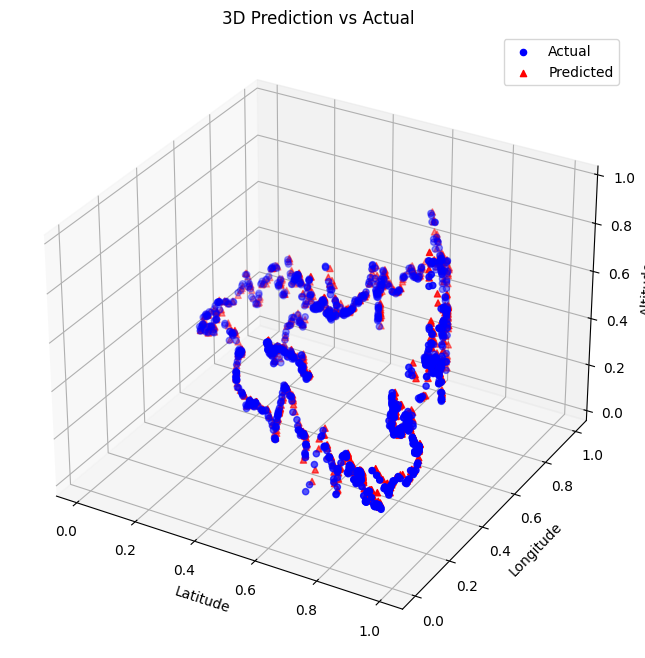

In [ ]:
# # 테스트 데이터 평가
# train_loader, val_loader, test_loader = prepare_dataloader(X_train, X_val, X_test, y_train, y_val, y_test, best_params['batch_size'])

# test_loss, true_values, predictions = evaluate_model(model, nn.MSELoss(), test_loader, 'cpu')
# print(f"Test Loss: {test_loss:.4f}")

# prediction_visualization(true_values, predictions)

In [ ]:
# !pip install torchinfo

# from torchinfo import summary

# summary(model, (1, 10, 3), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 109]              109,218
├─Linear: 1-2                            [1, 3]                    330
Total params: 109,548
Trainable params: 109,548
Non-trainable params: 0
Total mult-adds (M): 1.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.44
Estimated Total Size (MB): 0.45

In [ ]:
X_test.shape, y_test.shape

((1082, 10, 3), (1082, 3))

In [ ]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # 예시로 X_test와 y_test가 이렇게 생겼다고 가정
# X_test = np.random.rand(1082, 10, 3)
# y_test = np.random.rand(1082, 3)

# # min_max_scaler가 이미 학습되어 있다고 가정합니다.
# # 예시: min_max_scaler.fit(train_data)

# # X_test와 y_test를 원래 스케일로 되돌리기 위한 함수
# def inverse_min_max_scaling_X_y(X_test, y_test, scaler):
#     # 3D 데이터를 2D로 변경 (샘플 수 * 시퀀스 길이, feature)
#     X_test_2D = X_test.reshape(-1, X_test.shape[2])

#     # X_test 역변환 (스케일러는 feature 단위로 동작)
#     X_test_original = scaler.inverse_transform(X_test_2D)

#     # 다시 3D로 reshape (원래 형태로 복구)
#     X_test_original = X_test_original.reshape(X_test.shape)

#     # y_test는 2D이므로 바로 역변환
#     y_test_original = scaler.inverse_transform(y_test)

#     return X_test_original, y_test_original

# # 원래 스케일로 변환
# X_test_original, y_test_original = inverse_min_max_scaling_X_y(X_test, y_test, min_max_scaler)

# # 결과 확인
# print("Original X_test shape:", X_test_original.shape)
# print("Original y_test shape:", y_test_original.shape)


Original X_test shape: (1082, 10, 3)
Original y_test shape: (1082, 3)
